<a href="https://colab.research.google.com/github/SamuelSousaFerreira/pyspark/blob/main/Spark_Regress%C3%A3o_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 41 kB/s 
     |████████████████████████████████| 199 kB 46.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=a8d7f0b120bf61d040cf3703c7fd1f0bc2cac9c0fd27f23370ec20a934eca014
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


# Spark Session

O ponto de entrads para programar o Spark com API Dataset e DataFrame.
Uma SparkSession pode ser utilizada para criar DataFrames, registrar DataFrames como tabelas, executar consultas SQL em tabelas, armazenar em cachê e ler arquivos parquet. 
Para criar uma SparkSession, usamos o seguinte padrão de costrutor:

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master('local[*]')\
        .appName("Regressão com Spark")\
        .getOrCreate()

spark

# Carregamento dos Dados

## Montando o Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dados = spark.read.json('/content/drive/MyDrive/Cursos/pyspark/Regressão Com PySpark/imoveis.json')

In [5]:
dados

DataFrame[ident: struct<customerID:string,source:string>, listing: struct<address:struct<city:string,location:struct<lat:double,lon:double>,neighborhood:string,zone:string>,features:struct<bathrooms:bigint,bedrooms:bigint,floors:bigint,parkingSpaces:bigint,suites:bigint,totalAreas:string,unitFloor:bigint,unitsOnTheFloor:bigint,usableAreas:string>,prices:struct<price:string,tax:struct<condo:string,iptu:string>>,types:struct<unit:string,usage:string>>]

In [6]:
dados.show(truncate = False)

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{775564-BOJSMVON, Website}|{{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}, {0, 0, 0, 1, 0, 62, 0, 0, 62}, {45000, {150, 0}}, {Outros, Residencial}}                       |
|{660895-AUENKNYY, Website}|{{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}, {1, 2, 0, 1, 0, 0, 0, 0, 44}, {45000, {120, 0}}, {Apartamento, Residencial}}                |
|{751522-JESYFEQL, Website}|{{Rio de Janeiro,

In [7]:
dados.count()

73615

#Seleção de Features

In [8]:
dados.printSchema()

root
 |-- ident: struct (nullable = true)
 |    |-- customerID: string (nullable = true)
 |    |-- source: string (nullable = true)
 |-- listing: struct (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- location: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- neighborhood: string (nullable = true)
 |    |    |-- zone: string (nullable = true)
 |    |-- features: struct (nullable = true)
 |    |    |-- bathrooms: long (nullable = true)
 |    |    |-- bedrooms: long (nullable = true)
 |    |    |-- floors: long (nullable = true)
 |    |    |-- parkingSpaces: long (nullable = true)
 |    |    |-- suites: long (nullable = true)
 |    |    |-- totalAreas: string (nullable = true)
 |    |    |-- unitFloor: long (nullable = true)
 |    |    |-- unitsOnTheFloor: long (nullable = true)
 |    |    |-- usableAreas: string (nullable =

In [9]:
#selecionando os dados que interessam
dados\
    .select('ident.customerID','listing.*')\
    .show(truncate=False)

+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|customerID     |address                                                                         |features                       |prices               |types                     |
+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|775564-BOJSMVON|{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}                 |{0, 0, 0, 1, 0, 62, 0, 0, 62}  |{45000, {150, 0}}    |{Outros, Residencial}     |
|660895-AUENKNYY|{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}              |{1, 2, 0, 1, 0, 0, 0, 0, 44}   |{45000, {120, 0}}    |{Apartamento, Residencial}|
|751522-JESYFEQL|{Rio de Janeiro, {-22.986927, -43.646786}, Pedra de Guaratiba, Zona Oeste}      |{0

In [10]:
dados\
    .select('ident.customerID','listing.types.*','listing.features.*', 'listing.address.*','listing.prices.price','listing.prices.tax.*')\
    .show(truncate=False)

#analisando melhor os dados vamos refazer essa seleção para dados que podem ser úteis no nosso modelo

+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|totalAreas|unitFloor|unitsOnTheFloor|usableAreas|city          |location                |neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |62        |0        |0              |62         |Rio de Janeiro|{-22.909429, -43.413557}|Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1

In [11]:
dados\
    .select('ident.customerID','listing.types.*','listing.features.*', 'listing.address.*','listing.prices.price','listing.prices.tax.*')\
    .drop('city','location','totalAreas')\
    .show(truncate=False)
# dropo as que não serão úteis ao modelo

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste  |45000|120  |0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0     |0 

In [12]:
dataset = dados\
    .select('ident.customerID','listing.types.*','listing.features.*', 'listing.address.*','listing.prices.price','listing.prices.tax.*')\
    .drop('city','location','totalAreas')  

# Tratamento dos dados

In [13]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)



In [14]:
from pyspark.sql.types import IntegerType, DoubleType

In [15]:
dataset\
    .withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))\
    .withColumn('price', dataset['price'].cast(DoubleType()))\
    .withColumn('condo', dataset['condo'].cast(DoubleType()))\
    .withColumn('iptu', dataset['iptu'].cast(DoubleType()))\
    .printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: integer (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: double (nullable = true)
 |-- condo: double (nullable = true)
 |-- iptu: double (nullable = true)



In [16]:
dataset = dataset\
              .withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))\
              .withColumn('price', dataset['price'].cast(DoubleType()))\
              .withColumn('condo', dataset['condo'].cast(DoubleType()))\
              .withColumn('iptu', dataset['iptu'].cast(DoubleType()))


In [17]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo|  iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|   0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|   0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|  

In [18]:
#conhecendo os dados usage
dataset\
    .select('usage')\
    .groupBy('usage')\
    .count()\
    .show()


+-----------+-----+
|      usage|count|
+-----------+-----+
|  Comercial| 4019|
|Residencial|69596|
+-----------+-----+



Vemos que há apenas 4019 dados de imóveis comerciais, além de ser uma amostra muito pequena, o objetivo e prever preço de imóveis residenciais. Então vamos exluír os imóveis comerciais da nossa amostra.

In [19]:
dataset = dataset\
              .select('*')\
              .where("usage == 'Residencial'")

In [20]:
#conhecendo os dados unit
dataset\
    .select('unit')\
    .groupBy('unit')\
    .count()\
    .show()

+-----------+-----+
|       unit|count|
+-----------+-----+
|     Outros| 1190|
|Apartamento|59106|
|       Casa| 9300|
+-----------+-----+



In [21]:
#conhecendo as zonas
dataset\
    .select('zone')\
    .groupBy('zone')\
    .count()\
    .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



Unit estão com os dados ok, os 'outros' podem ser stúdio ou outro tipo de imóvel, o que demandaria um conhecimento melhor do negócio.
Já as zonas aparecem 157 com dados em branco e veremos como tratar nas próximas sessões.
## Tratamento dos dados Faltantes

In [22]:
from pyspark.sql import functions as f

In [23]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|  0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|       

In [25]:
#contando os valores nulos ou NaN

dataset\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
    .show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0| 6061|8726|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [26]:
dataset\
    .select('*')\
    .na\
    .fill(0)\
    .show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|  0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|       

In [27]:
dataset =  dataset\
            .select('*')\
            .na\
            .fill(0)

In [30]:
#verificando os valores vazios
dataset\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
    .show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0|    0|   0|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [31]:
#tratando string vazia
dataset\
    .select('zone')\
    .groupBy('zone')\
    .count()\
    .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
+------------+-----+



In [32]:
dataset = dataset\
          .where(f.col('zone') != '' )

# **Regressão Linear**

1.   List item

1.   List item
2.   List item


2.   List item


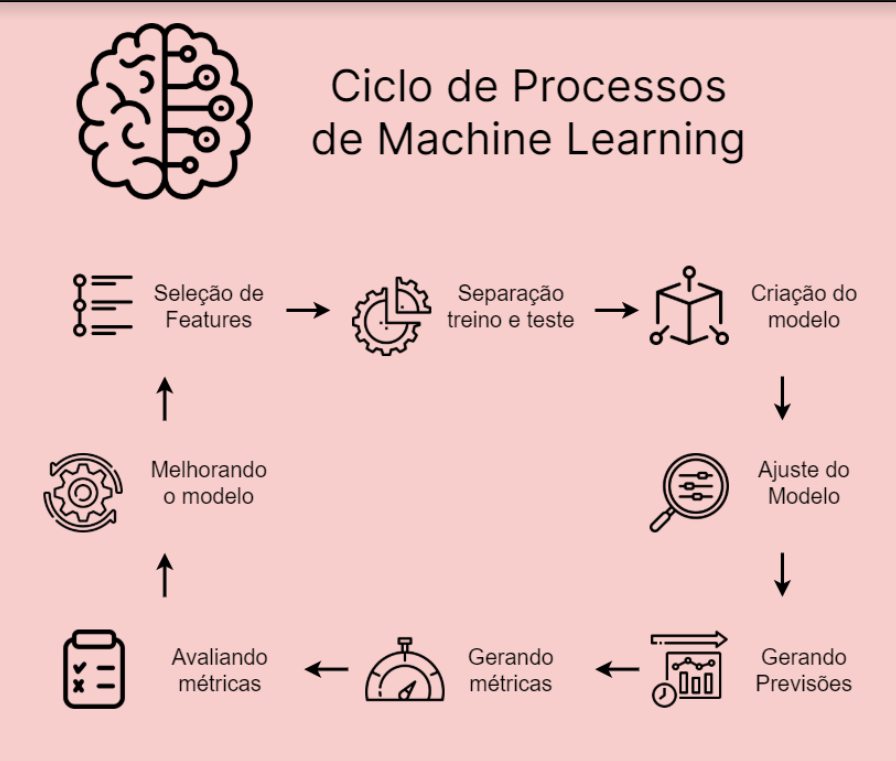

## **Preparação dos dados**
###[ Variáveis Dummy](https://medium.com/data-hackers/vari%C3%A1veis-dummy-o-que-%C3%A9-quando-usar-e-como-usar-78de66cfcca9)


In [33]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|  0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|       

In [34]:
dataset\
    .groupBy('customerID')\
    .pivot('unit')\
    .agg(f.lit(1))\
    .na\
    .fill(0)\
    .show()

+---------------+-----------+----+------+
|     customerID|Apartamento|Casa|Outros|
+---------------+-----------+----+------+
|062130-QKYMWGMV|          1|   0|     0|
|630945-AEEUPRXI|          0|   1|     0|
|994985-OZQNHQKH|          1|   0|     0|
|494674-JWXRZIBM|          1|   0|     0|
|458844-UJCRFSRI|          1|   0|     0|
|155284-BRCDAOIQ|          1|   0|     0|
|396742-DUXBHLRU|          1|   0|     0|
|916072-ZJXARAXO|          1|   0|     0|
|943843-BVTWWHRQ|          1|   0|     0|
|193126-MTNIIFQN|          1|   0|     0|
|319762-UXTTQYFS|          1|   0|     0|
|931151-GZCTKADB|          1|   0|     0|
|103840-OFKPFEZJ|          0|   1|     0|
|176885-NNKZRQGM|          0|   1|     0|
|926638-PBYRAZYR|          1|   0|     0|
|744421-IZJWISWB|          1|   0|     0|
|530012-TYGLQMER|          1|   0|     0|
|209407-GTEUOVKR|          1|   0|     0|
|289667-ZPHGFHJH|          1|   0|     0|
|859388-EYTPMKER|          1|   0|     0|
+---------------+-----------+----+

In [35]:
unit = dataset\
    .groupBy('customerID')\
    .pivot('unit')\
    .agg(f.lit(1))\
    .na\
    .fill(0) 

In [36]:
zone = dataset\
    .groupBy('customerID')\
    .pivot('zone')\
    .agg(f.lit(1))\
    .na\
    .fill(0) 

In [37]:
dataset = dataset\
    .join(unit, on = 'customerID', how='inner')\
    .join(zone, on = 'customerID', how='inner')

In [38]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

Spark precisa da vetorização dos dados que é a transformação da colunas no dataset em um vetor pois é assim que o spark trabalha.

In [39]:
from pyspark.ml.feature import VectorAssembler

In [40]:
dataset = dataset.withColumnRenamed('price','label') # a partir de agora referiremos ao preço como label

In [41]:
#criando um vetor com as variáveis que interessam
X = [
     'bathrooms',
     'bedrooms',
     'floors',
     'parkingSpaces',
     'suites',
     'unitFloor',
     'unitsOnTheFloor',
     'usableAreas',
     'condo',
     'iptu',
     'Apartamento',
     'Casa',
     'Outros',
     'Zona Central',
     'Zona Norte',
     'Zona Oeste',
     'Zona Sul'
]

In [42]:
assembler = VectorAssembler(inputCols = X, outputCol= 'features')

In [43]:
dataset.show() #não foram aplicadas alterações no dataset

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  label|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

In [44]:
dataset_prep = assembler.transform(dataset).select('features','label')

In [45]:
dataset_prep.show(10, truncate= False)

+--------------------------------------------------------------------------+-------+
|features                                                                  |label  |
+--------------------------------------------------------------------------+-------+
|(17,[3,7,8,12,15],[1.0,62.0,150.0,1.0,1.0])                               |45000.0|
|(17,[0,1,3,7,8,10,15],[1.0,2.0,1.0,44.0,120.0,1.0,1.0])                   |45000.0|
|(17,[7,8,12,15],[132.0,100.0,1.0,1.0])                                    |50000.0|
|[2.0,3.0,3.0,1.0,1.0,2.0,4.0,60.0,400.0,120.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0]|50000.0|
|(17,[7,12,15],[200.0,1.0,1.0])                                            |50000.0|
|(17,[0,1,3,7,10,14],[1.0,1.0,1.0,33.0,1.0,1.0])                           |45336.0|
|(17,[7,12,15],[120.0,1.0,1.0])                                            |45000.0|
|(17,[7,12,15],[468.0,1.0,1.0])                                            |45000.0|
|(17,[5,7,12,15],[1.0,180.0,1.0,1.0])                            

## Exploração dos dados

In [46]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [47]:
correlacao = Correlation.corr(dataset = dataset_prep, column = 'features').collect()

In [48]:
correlacao

[Row(pearson(features)=DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False))]

In [49]:
correlacao = Correlation.corr(dataset = dataset_prep, column = 'features').collect()[0][0]

In [50]:
correlacao

DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False)

0 não é representado na sparse e na densa sim.
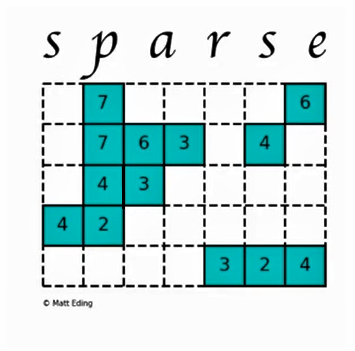

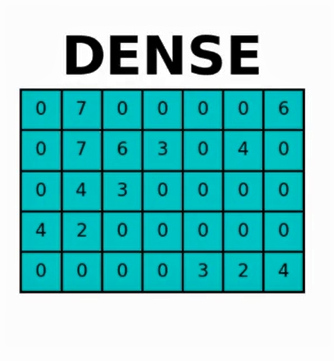

In [51]:
correlacao.toArray()

array([[ 1.00000000e+00,  6.65910814e-01, -4.45907541e-02,
         4.87590447e-01,  7.52927830e-01,  7.62425469e-03,
        -1.07437445e-01,  5.98072790e-01,  2.00298945e-02,
         1.51023977e-02, -2.75457964e-01,  3.43042378e-01,
        -1.40183420e-01, -9.73678190e-02, -1.62497441e-01,
         2.42345124e-01, -9.87517576e-02],
       [ 6.65910814e-01,  1.00000000e+00, -8.21840063e-02,
         4.67161260e-01,  6.01199220e-01, -7.16195849e-03,
        -1.30814438e-01,  5.63750247e-01,  1.84819307e-02,
         1.36391535e-02, -2.58339018e-01,  3.49962189e-01,
        -2.05607705e-01, -1.23732152e-01, -1.11711865e-01,
         1.63821698e-01, -4.94325200e-02],
       [-4.45907541e-02, -8.21840063e-02,  1.00000000e+00,
        -4.84861921e-02, -4.81062141e-02,  1.20981700e-01,
         7.37717422e-01, -1.03916850e-01,  1.37973623e-02,
         6.68849447e-03,  1.53947015e-01, -1.42089598e-01,
        -5.19462291e-02,  1.26044467e-01, -1.69262936e-02,
        -3.17495417e-02,  1.7

In [52]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns= X, index=X)

In [53]:
dataframe_correlacao

,bathrooms,bedrooms,floors,parkingSpaces,suites,unitFloor,unitsOnTheFloor,usableAreas,condo,iptu,Apartamento,Casa,Outros,Zona Central,Zona Norte,Zona Oeste,Zona Sul
bathrooms,1.000000,0.665911,-0.044591,0.487590,0.752928,0.007624,-0.107437,0.598073,0.020030,0.015102,-0.275458,0.343042,-0.140183,-0.097368,-0.162497,0.242345,-0.098752
bedrooms,0.665911,1.000000,-0.082184,0.467161,0.601199,-0.007162,-0.130814,0.563750,0.018482,0.013639,-0.258339,0.349962,-0.205608,-0.123732,-0.111712,0.163822,-0.049433
floors,-0.044591,-0.082184,1.000000,-0.048486,-0.048106,0.120982,0.737717,-0.103917,0.013797,0.006688,0.153947,-0.142090,-0.051946,0.126044,-0.016926,-0.031750,0.017402
parkingSpaces,0.487590,0.467161,-0.048486,1.000000,0.484988,0.003768,-0.074527,0.483732,0.018012,0.009721,-0.252746,0.293326,-0.072359,-0.086437,-0.109957,0.267990,-0.178807
suites,0.752928,0.601199,-0.048106,0.484988,1.000000,0.005206,-0.091914,0.577636,0.023461,0.019093,-0.236217,0.282221,-0.088834,-0.084417,-0.230317,0.327546,-0.136398
unitFloor,0.007624,-0.007162,0.120982,0.003768,0.005206,1.000000,0.092359,-0.012748,0.003065,0.001200,0.034674,-0.031403,-0.013275,0.022315,-0.011112,0.007518,-0.004333
unitsOnTheFloor,-0.107437,-0.130814,0.737717,-0.074527,-0.091914,0.092359,1.000000,-0.144222,-0.000554,0.005029,0.147497,-0.137754,-0.045523,0.153639,0.030753,-0.012434,-0.055540
usableAreas,0.598073,0.563750,-0.103917,0.483732,0.577636,-0.012748,-0.144222,1.000000,0.019717,0.014656,-0.482170,0.459136,0.125672,-0.075256,-0.158553,0.192466,-0.051962
condo,0.020030,0.018482,0.013797,0.018012,0.023461,0.003065,-0.000554,0.019717,1.000000,0.226212,0.009105,-0.008624,-0.002495,-0.003553,-0.013453,-0.001055,0.014474
iptu,0.015102,0.013639,0.006688,0.009721,0.019093,0.001200,0.005029,0.014656,0.226212,1.000000,-0.001502,0.002291,-0.001870,-0.002438,-0.008400,-0.000428,0.008835


Multicolinearidade refere-se à correlação entre duas variáveis explicativas ou entre uma delas e as demais incluídas na equação de um modelo. Quando a correlação entre variáveis explicativas é alta, a eficiência dos coeficientes estimados diminui e, em consequência disso, a variância da estimativa aumenta.

1) Ausência de multicolinearidade: ocorre quando a correlação entre as variáveis explicativas é nula. Essa é a situação ideal.

2) Multicolinearidade perfeita: nesse caso, a correlação entre as variáveis explicativas é igual a 1 ou -1. O cálculo das estimativas dos parâmetros é matematicamente impossível nessas circunstâncias.

3) Multicolinearidade imperfeita: ocorre quando a correlação entre as variáveis está entre 0 e 1 ou -1 e 0. Esse é o caso mais comum.

A multicolinearidade aumenta os erros padrão dos coeficientes. O aumento destes, por sua vez, significa que os coeficientes para algumas variáveis explicativas podem não ser significativamente diferentes de 0. Em outras palavras, ao super-inflacionar os erros padrão, a multicolinearidade torna algumas variáveis estatisticamente insignificantes quando deveriam ser significativas.

Portanto, caso duas variáveis explicativas apresentem alta correlação entre si, removemos uma delas para que não ocorra nenhum problema da estimação dos coeficientes. Além disso, por elas terem alta correlação, estão explicando quase o mesmo comportamento, ou seja, estão sendo ambíguas

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

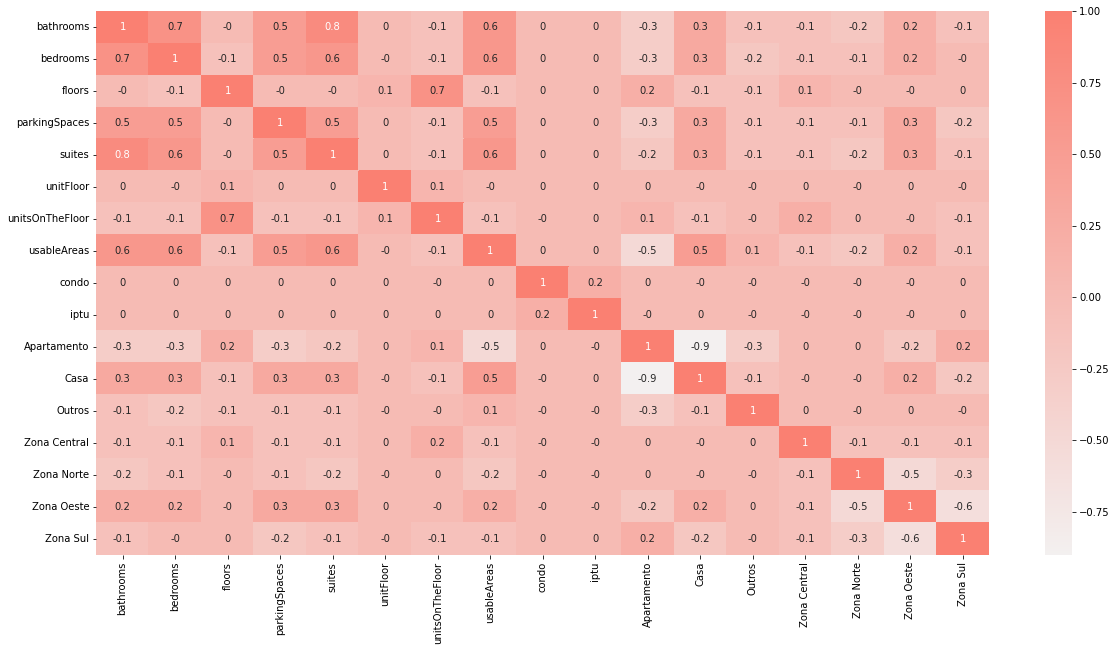

In [55]:
plt.figure(figsize=(20,10))

paleta = sns.color_palette('light:salmon', as_cmap=True)

sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

## Ajuste e Previsão

In [56]:
from pyspark.ml.regression import LinearRegression

In [57]:
treino, teste = dataset_prep.randomSplit([0.7,0.3], seed = 101)

In [58]:
treino.count()

48528

In [59]:
teste.count()

20911

In [60]:
lr = LinearRegression()

In [61]:
modelo_lr = lr.fit(treino)

In [62]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [63]:
previsoes_lr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|443266.04737020144|
|(17,[0,1,2,3,4,5,...|500000.0|1127455.8300462805|
|(17,[0,1,2,3,4,5,...|308615.0|111210.49949889386|
|(17,[0,1,2,3,4,5,...|279000.0|113587.95787719043|
|(17,[0,1,2,3,4,5,...|545000.0|340703.71307873435|
|(17,[0,1,2,3,4,5,...|449000.0|390571.99595798284|
|(17,[0,1,2,3,4,5,...|479000.0| 444003.4297194885|
|(17,[0,1,2,3,4,5,...|420000.0| 720022.1542161054|
|(17,[0,1,2,3,4,5,...|265000.0|519406.05037395435|
|(17,[0,1,2,3,4,5,...|490000.0| 845483.5388437647|
|(17,[0,1,2,3,4,5,...|650000.0| 644931.4982488954|
|(17,[0,1,2,3,4,5,...|379900.0| 448889.3339027724|
|(17,[0,1,2,3,4,5,...|449000.0| 714548.9501108339|
|(17,[0,1,2,3,4,5,...|190000.0| 411726.9411630478|
|(17,[0,1,2,3,4,5,...|896000.0| 597499.4601552959|
|(17,[0,1,2,3,4,5,...|679000.0| 864544.0129262989|
|(17,[0,1,2,3,4,5,...|620000.0|

## Métricas
- R2 Quanto que o modelo está ajustado aos dados, quanto que reflete a realidade dos dados.
- RMSE raiz quadrada do  erro médio elevado ao quadrado


In [64]:
resumo_treino = modelo_lr.summary

In [65]:
resumo_treino.r2 #significa que temos 665 de ajuste do modelo aos dados

0.6655873678454578

In [66]:
resumo_treino.rootMeanSquaredError #quanto menor melhor é

810348.969531623

In [67]:
resumo_teste = modelo_lr.evaluate(teste)

In [68]:
resumo_teste.r2

0.6585207937774393

In [69]:
resumo_teste.rootMeanSquaredError

800525.9696828632

## Tabela Regressão Linear

In [70]:
print('Linear Regresion')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)


Linear Regresion
Dados de Treino
R²: 0.665587
RMSE: 810348.969532

Dados de Teste
R²: 0.658521
RMSE: 800525.969683


# **Decision Tree**

[Documentação](
  https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.DecisionTreeRegressor.html)

In [71]:
from pyspark.ml.regression import DecisionTreeRegressor

In [72]:
dtr = DecisionTreeRegressor(seed=101, maxDepth=7)

In [73]:
modelo_dtr = dtr.fit(treino)

In [74]:
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [75]:
previsoes_dtr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|500000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|308615.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|279000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|545000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|479000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|420000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|265000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|490000.0|  820272.937751004|
|(17,[0,1,2,3,4,5,...|650000.0|  736254.943802521|
|(17,[0,1,2,3,4,5,...|379900.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|190000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|896000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|679000.0|1158420.7653661144|
|(17,[0,1,2,3,4,5,...|620000.0|

## Métricas
Usaremos o [avaliador de regressão](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html)


In [76]:
from pyspark.ml.evaluation import RegressionEvaluator

In [77]:
evaluator = RegressionEvaluator()

In [79]:
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))

0.7930752588471226
637436.5434260432


In [80]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [81]:
previsoes_dtr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 350000.0|  820272.937751004|
|(17,[0,1,2,3,4,5,...| 340000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 430000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 600000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 439000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 333000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 948000.0|  736254.943802521|
|(17,[0,1,2,3,4,5,...| 459600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 447600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 360000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 407000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 310000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|1400000.0|1289301.4891122277|
|(17,[0,1,2,3,4,5,...|1180000.0|1289301.4891122277|
|(17,[0,1,2,3,4,5,...|1299500.0|1158420.7653661144|
|(17,[0,1,2,

In [82]:
print('Decision Tree Regresion')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regresion
Dados de Treino
R²: 0.793075
RMSE: 637436.543426

Dados de Teste
R²: 0.773813
RMSE: 651518.489921


# **Random Forest**
[Documentação](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html
)

In [91]:
from pyspark.ml.regression import RandomForestRegressor

In [92]:
rfr = RandomForestRegressor(seed =101, maxDepth=7, numTrees=10)

In [93]:
modelo_rfr = rfr.fit(treino)

In [96]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [87]:
previsoes_rfr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|390218.33742322924|
|(17,[0,1,2,3,4,5,...|500000.0| 510060.6595782173|
|(17,[0,1,2,3,4,5,...|308615.0|360766.74127901345|
|(17,[0,1,2,3,4,5,...|279000.0|360766.74127901345|
|(17,[0,1,2,3,4,5,...|545000.0|  396904.928725379|
|(17,[0,1,2,3,4,5,...|449000.0|  492913.652312712|
|(17,[0,1,2,3,4,5,...|479000.0|433807.13396085694|
|(17,[0,1,2,3,4,5,...|420000.0| 664440.4325776277|
|(17,[0,1,2,3,4,5,...|265000.0|479615.50733929937|
|(17,[0,1,2,3,4,5,...|490000.0| 816123.0337632223|
|(17,[0,1,2,3,4,5,...|650000.0| 640247.1517314625|
|(17,[0,1,2,3,4,5,...|379900.0|403131.21721626434|
|(17,[0,1,2,3,4,5,...|449000.0|403131.21721626434|
|(17,[0,1,2,3,4,5,...|190000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...|896000.0| 547828.3209496561|
|(17,[0,1,2,3,4,5,...|679000.0| 893791.6624292185|
|(17,[0,1,2,3,4,5,...|620000.0|

## Métricas

In [88]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))

0.8017561510914318
623922.4426224458


In [97]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [98]:
previsoes_rfr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 350678.0454640939|
|(17,[0,1,2,3,4,5,...| 350000.0| 792518.9735011571|
|(17,[0,1,2,3,4,5,...| 340000.0|479615.50733929937|
|(17,[0,1,2,3,4,5,...| 430000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 600000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 439000.0| 550795.8732599718|
|(17,[0,1,2,3,4,5,...| 333000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 948000.0| 640247.1517314625|
|(17,[0,1,2,3,4,5,...| 459600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 447600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 360000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 407000.0|  492913.652312712|
|(17,[0,1,2,3,4,5,...| 310000.0|412580.35636663495|
|(17,[0,1,2,3,4,5,...|1400000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1180000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1299500.0|1111896.8209940076|
|(17,[0,1,2,

In [99]:
print('Random Forest Regresion')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regresion
Dados de Treino
R²: 0.801756
RMSE: 623922.442622

Dados de Teste
R²: 0.790530
RMSE: 626981.467738
